In [1]:
#Imports used: 
import pandas as pd #For data loading/cleaning
import numpy as np #For numerical analysis
from scipy.stats import pearsonr #For Pearson Correlation Test
import statsmodels.api as sm #For OLS Regression modeling
import seaborn as sns #For statistical modeling
import matplotlib.pyplot as plt #For visualizations
import plotly.express as px #For choropleth visualization

In [2]:
#Importing CSV datafiles
broadband_path = "broadband.csv" #broadband data
remotework_path = "remotework.csv" #remote work data
broadband = pd.read_csv(broadband_path)
remotework = pd.read_csv(remotework_path)
#Printing the number or rows and columns for both data sets
print(f"Broadband Data (Rows, Columns):", broadband.shape)
print(f"\nBroadband Data First 5 rows:\n", broadband.head(5))
print(f"\nRemote Work Data (Rows, Columns):", remotework.shape)
print(f"\nRemote Word Data First 5 Rows:\n", remotework.head(5))

Broadband Data (Rows, Columns): (21018, 13)

Broadband Data First 5 rows:
   area_data_type geography_type geography_id geography_desc    total_area  \
0          Total       National           99       National  9.754824e+06   
1          Total          State           01        Alabama  1.370274e+05   
2          Total          State           02         Alaska  1.846753e+06   
3          Total          State           04        Arizona  2.573078e+05   
4          Total          State           05       Arkansas  1.310934e+05   

   mobilebb_3g_area_st_pct  mobilebb_3g_area_iv_pct  mobilebb_4g_area_st_pct  \
0                 0.061412                 0.042772                 0.687817   
1                 0.000000                 0.000000                 0.946387   
2                 0.081332                 0.053745                 0.073886   
3                 0.070936                 0.047557                 0.725504   
4                 0.000000                 0.000000           

In [3]:
#Printing a concise summary of the dataframes
print(f"Broadband Data:")
broadband.info(verbose=True)
print(f"\nRemote Work Data:")
remotework.info(verbose=True)

Broadband Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21018 entries, 0 to 21017
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   area_data_type                21018 non-null  object 
 1   geography_type                21018 non-null  object 
 2   geography_id                  21018 non-null  object 
 3   geography_desc                21018 non-null  object 
 4   total_area                    21018 non-null  float64
 5   mobilebb_3g_area_st_pct       21018 non-null  float64
 6   mobilebb_3g_area_iv_pct       21018 non-null  float64
 7   mobilebb_4g_area_st_pct       21018 non-null  float64
 8   mobilebb_4g_area_iv_pct       21018 non-null  float64
 9   mobilebb_5g_spd1_area_st_pct  21018 non-null  float64
 10  mobilebb_5g_spd1_area_iv_pct  21018 non-null  float64
 11  mobilebb_5g_spd2_area_st_pct  21018 non-null  float64
 12  mobilebb_5g_spd2_area_iv_pct  21018 non-null

In [9]:
#Exploring the datasets to determine how to merge
broadband[["geography_type", "geography_id", "geography_desc"]].head() #Columns to compare with remotework data
remotework[["STATEFP", "COUNTYFP", "TRACTCE", "NAMELSAD", "NAME"]].head() #Columns to compare with broadband data
#broadband's column 'geography_id' and remotework's column 'STATEFP' both have a correlating state number but different format

,STATEFP,COUNTYFP,TRACTCE,NAMELSAD,NAME
0,4,1,945001,Census Tract 9450.01,Census Tract 9450.01; Apache County; Arizona
1,4,1,945002,Census Tract 9450.02,Census Tract 9450.02; Apache County; Arizona
2,4,1,945100,Census Tract 9451,Census Tract 9451; Apache County; Arizona
3,4,1,970201,Census Tract 9702.01,Census Tract 9702.01; Apache County; Arizona
4,4,1,970202,Census Tract 9702.02,Census Tract 9702.02; Apache County; Arizona


In [15]:
#Cleaning the broadband dataset
#Filtering broadband dataset to states only: 
broadband_states = broadband[broadband["geography_type"] == "State"].copy()
#Converting geography_id to a new column that will be a common key between both datasets
broadband_states["state_fp"] = broadband_states["geography_id"].astype(str).str.zfill(2) #Creating standardized column for key using FIP score
broadband_states[["state_fp", "geography_desc"]].head()
#Combining broadband availability percentages 
broadband_cols = ["mobilebb_3g_area_st_pct","mobilebb_4g_area_st_pct","mobilebb_5g_spd1_area_st_pct","mobilebb_5g_spd2_area_st_pct"]
#Calculating mean of broadband scores
broadband_states["broadband_score"] = broadband_states[broadband_cols].mean(axis=1)
#Reducing dataset to one row per state
broadband_by_state = (broadband_states[["geography_id", "geography_desc", "broadband_score"]].groupby(["geography_id", "geography_desc"], as_index=False).mean())
broadband_by_state["state_fp"] = broadband_by_state["geography_id"].astype(str).str.zfill(2)
broadband_by_state.head()

,geography_id,geography_desc,broadband_score,state_fp
0,01,Alabama,0.560279,01
1,02,Alaska,0.244889,02
2,04,Arizona,0.434850,04
3,05,Arkansas,0.565485,05
4,06,California,0.492273,06


In [16]:
#Cleaning remotework dataset 
#Converting STATEFP to a new column that will be a common key between both datasets
remotework_states = remotework.copy()
remotework_states["STATEFP_str"] = (remotework_states["STATEFP"].astype(str).str.zfill(2)) #Creating standardized column for key using FIP score
#Aggregating remotework dataset to state level instead of county:
remotework_by_state = (remotework_states.groupby("STATEFP_str", as_index=False).agg(total_workers=("Total workers", "sum"), total_wfh=("Workers working from home", "sum")))
#Computing remote work percent by state:
remotework_by_state["wfh_pct_state"] = (remotework_by_state["total_wfh"] / remotework_by_state["total_workers"] * 100)
remotework_by_state.head()

,STATEFP_str,total_workers,total_wfh,wfh_pct_state
0,01,2202219,171143,7.771389
1,02,351270,30903,8.797506
2,04,3306501,546481,16.527471
3,05,1313067,102122,7.777364
4,06,18331098,2832962,15.454404


In [21]:
#Merging broadband and remotework datasets on FIP code key:
broadband_remotework = broadband_by_state.merge(remotework_by_state, left_on="state_fp", right_on="STATEFP_str",how="inner")
broadband_remotework.rename(columns={"geography_desc":"State"}, inplace=True) #Renaming column
broadband_remotework.info() #Printing mergedd dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geography_id     52 non-null     object 
 1   State            52 non-null     object 
 2   broadband_score  52 non-null     float64
 3   state_fp         52 non-null     object 
 4   STATEFP_str      52 non-null     object 
 5   total_workers    52 non-null     int64  
 6   total_wfh        52 non-null     int64  
 7   wfh_pct_state    52 non-null     float64
dtypes: float64(2), int64(2), object(4)
memory usage: 3.4+ KB


In [24]:
#Mapping STATEFP_str to state abbreviations for future choropleth use:
fp_to_abbrev = {"01": "AL", "02": "AK", "04": "AZ", "05": "AR", "06": "CA","08": "CO", "09": "CT", "10": "DE", "11": "DC", "12": "FL","13": "GA", "15": "HI", "16": "ID", "17": "IL", "18": "IN","19": "IA", "20": "KS", "21": "KY", "22": "LA", "23": "ME","24": "MD", "25": "MA", "26": "MI", "27": "MN", "28": "MS","29": "MO", "30": "MT", "31": "NE", "32": "NV", "33": "NH","34": "NJ", "35": "NM", "36": "NY", "37": "NC", "38": "ND","39": "OH", "40": "OK", "41": "OR", "42": "PA", "44": "RI","45": "SC", "46": "SD", "47": "TN", "48": "TX", "49": "UT","50": "VT", "51": "VA", "53": "WA", "54": "WV", "55": "WI","56": "WY"}
#Creating state_abbrev column by mapping to FIP Score
broadband_remotework["state_abbrev"] = broadband_remotework["STATEFP_str"].map(fp_to_abbrev)
#Removing territories that were not mapped: 
broadband_remotework = broadband_remotework.dropna(subset=["state_abbrev"])
#Verifying that states were mapped correctly
broadband_remotework.head()

,geography_id,State,broadband_score,state_fp,STATEFP_str,total_workers,total_wfh,wfh_pct_state,state_abbrev
0,01,Alabama,0.560279,01,01,2202219,171143,7.771389,AL
1,02,Alaska,0.244889,02,02,351270,30903,8.797506,AK
2,04,Arizona,0.434850,04,04,3306501,546481,16.527471,AZ
3,05,Arkansas,0.565485,05,05,1313067,102122,7.777364,AR
4,06,California,0.492273,06,06,18331098,2832962,15.454404,CA


In [28]:
#Data Analysis
#Performing descriptive statistics:
print(f"Descriptive Statistics:\n",broadband_remotework.describe())

Descriptive Statistics:
        broadband_score  total_workers     total_wfh  wfh_pct_state
count        51.000000   5.100000e+01  5.100000e+01      51.000000
mean          0.556902   3.090284e+06  4.169818e+05      12.593011
std           0.100167   3.475112e+06  5.117459e+05       4.027668
min           0.244889   2.827690e+05  2.415300e+04       5.286633
25%           0.484674   8.080935e+05  1.004900e+05       9.767037
50%           0.582936   2.002703e+06  2.374240e+05      11.963626
75%           0.631932   3.680178e+06  5.880445e+05      15.039077
max           0.748121   1.833110e+07  2.832962e+06      29.443479


In [29]:
#Data Analysis
#Performing Correlation Analysis: 
print(f"Correlation between broadband access and remote work:\n",broadband_remotework[["broadband_score", "wfh_pct_state"]].corr())
#Conducting a Pearson Correlation Analysis:
corr_value, p_value = pearsonr(broadband_remotework["broadband_score"], broadband_remotework["wfh_pct_state"])
print(f"\nCorrelation Coefficient:", corr_value)
print(f"\nP Value:", p_value)

Correlation between broadband access and remote work:
                  broadband_score  wfh_pct_state
broadband_score         1.000000       0.086395
wfh_pct_state           0.086395       1.000000

Correlation Coefficient: 0.08639529642875395

P Value: 0.5466291877791701


In [30]:
#Data Analysis
#Performing linear regression analysis between broadband access and remote work
X = broadband_remotework["broadband_score"]
y = broadband_remotework["wfh_pct_state"]
#Adding the intercept
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          wfh_pct_state   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.3685
Date:                Fri, 12 Dec 2025   Prob (F-statistic):              0.547
Time:                        20:54:41   Log-Likelihood:                -142.72
No. Observations:                  51   AIC:                             289.4
Df Residuals:                      49   BIC:                             293.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.6584      3.237     

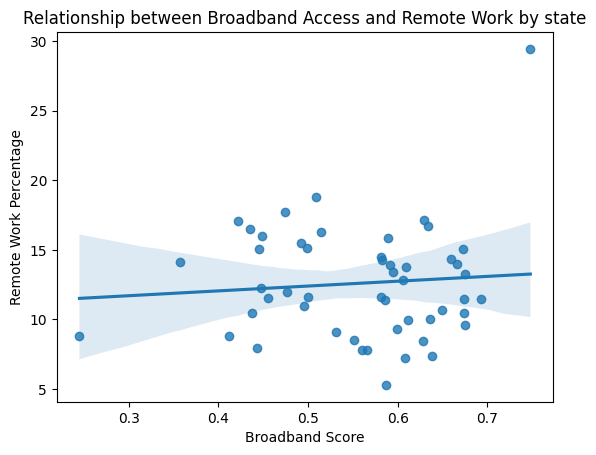

In [31]:
#Creating a visualization of data plot and a linear regression model fit
sns.regplot(data=broadband_remotework, x="broadband_score", y="wfh_pct_state")
plt.xlabel("Broadband Score")
plt.ylabel("Remote Work Percentage")
plt.title("Relationship between Broadband Access and Remote Work by state")
plt.show()

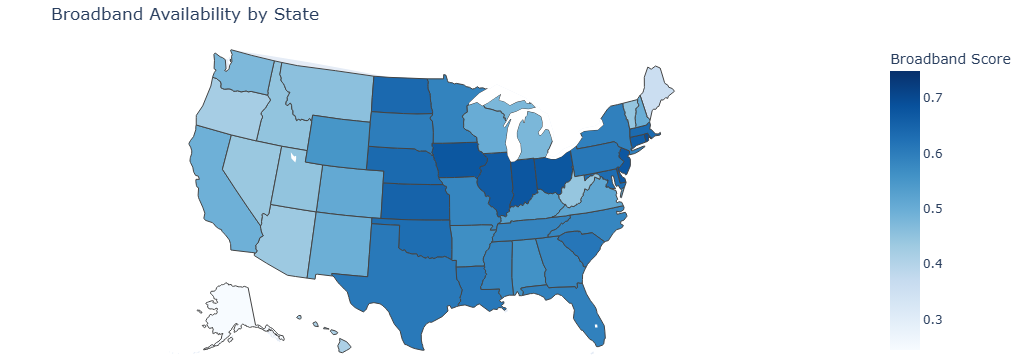

In [32]:
#Creating a choropleth visualization 
map_broadband = px.choropleth(broadband_remotework, locations="state_abbrev", locationmode="USA-states", color="broadband_score",scope="usa",color_continuous_scale="Blues",labels={"broadband_score":"Broadband Score", "wfh_pct_state": "Remote Work Percentage"},hover_name="State",hover_data={"state_abbrev": False, "wfh_pct_state": True})
map_broadband.update_layout(title="Broadband Availability by State", margin=dict(l=0, r=0, t=40, b=0))
map_broadband.show()

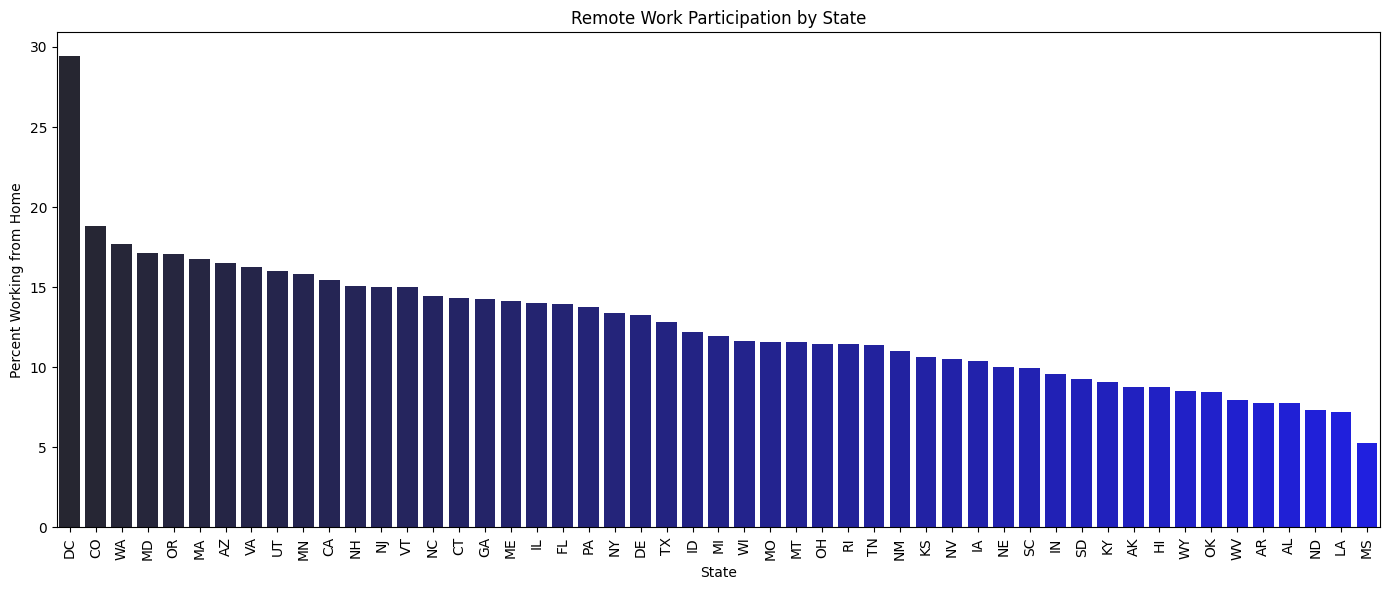

In [33]:
#Creating barplot showing average remote work percentage by state
plt.figure(figsize=(14,6))
sns.barplot(data=broadband_remotework.sort_values("wfh_pct_state", ascending=False), x="state_abbrev", y="wfh_pct_state", hue="state_abbrev", palette='dark:blue')
plt.xlabel("State")
plt.ylabel("Percent Working from Home")
plt.title("Remote Work Participation by State")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()